<h1><center> Network Simulation

<h3><center> Michelle Hackl <h4><center>CS166, Prof. Ribeiro
--------

### Part 0 - Existing Model

The existing model has 3 parameters: $\alpha$, $\beta$ and $\gamma$ and two update equations that determine changes in edge weights (relationship strength) and node weights (opinions).

$$\begin{align}
&\Delta o_i = \alpha w_{ij} (o_i - o_j) \\ \\
&\Delta w_{ij} = \beta w_{ij} 1-w_{ij}) (1-\gamma |o_i - o_j|) \\
\end{align}$$


$\alpha$ denotes the speed of opinion change with which the nodes will change their opinions to fit or move away from their neighbors. 
$$\begin{align} \alpha \in (0, 0.5] \end{align}$$

$\beta$ scales the amount by which weights change, meaning how quickly differing opinions can affect the strength of an existing relationship between two nodes.
$$\begin{align} \beta \in (0, 1) \end{align}$$


$\gamma$ determines how much a difference in opinions affects weight change. If $\gamma <$ 0, denoting nodes not being affected particularly by their differing opinions, weights will converge to 1. If $|o_i-o_j| > \gamma ^{-1} w_{ij}$, weights will decrease steadily.
$$\begin{align}
\gamma &> 0 \\  
|o_i-o_j| &> \gamma ^{-1} w_{ij}
\end{align}$$

### Part 1 - Proposed Modifications
#### Scenario 1 - Relationship age

One way to make the connections in the network more realistic is to consider how long they have existed. If two nodes have been connected for a really long time, the nodes are more likely to carefully consider each other's opinions, even if they differ fundamentally. Assuming that if the nodes have managed to stay connected for a long time, they value each other's opinions more. But of course, the way in which relationship length influences people is not merely dependent on the absolute time, but rather might be modelled as a function of how long the relationship has existed in comparison to others that the node has. The "oldest friend" is hence just the one that has been around for the longest time, compared to our other friends. I will introduce a new parameter $\tau$ that models this phenomenon. Since $\tau$ now determines how much relationships can influence our opinion, we will let it replace $\alpha$, and define it as follows:

$$\begin{align}
&\Delta o_i = \tau\ w_{ij} (o_i - o_j), where \\ \\
&\tau = \frac{age(w_{ij})}{2 \sum(neighbor's\ edge\ age) },\ \ \tau \geq \alpha \\
\end{align}$$

$\tau$ is normalized over 2 * sum(age of all neighboring weights) and hence has the same potential values as $\alpha$ would, with the differences that it depends on connection age relative to a node's total connections' ages.

Since our model performs asynchronous updating, the age of a relationship will be determined by the number of times two nodes have interacted with one another, rather than the total age of the simulation. We will assume a basic level of trust between people, however, allowing new relationships to influence us at least to the same extent that the default alpha would suggest for all relationships.

#### Scenario 2 - Making an effort
From Part 2 we can see that our networks are prone to generating clusters of differing opinions for a large range of parameters. What differences might it make now, if people were to make an effort to connect more people with differing opinions? For the second modification I will add a rule by which, occasionally (3% chance), a person will select the two of their friends with the largest differing opinion and introduce them to one another. Then I will analyze if this effort indeed allows people to keep clusters connected or if it will merely lead to opinions converging faster within clusters (since I simply ensure that my friends converge in opinions).

## Part 2 - Local Analysis
Below I have plotted the vector fields for all three parameters of my model. Note that for scenario 1, tau is merely an altered version of alpha, with at least the value of alpha ($\tau \geq \alpha$). Hence, we would expect the model using $\tau$ to converge in opinions _at least_ as fast as the default, but most likely faster.
Given that tau, however, varies for each node now, we cannot directly derive its impact on the model from a local analysis alone. 

We can, however, approximate the impact that $\tau$ will have on the model by its formula, if we assume the age of any given node is simply an average age (or how often nodes interact on average) and reexpress our sum over all neighbor's edge ages as the average age times a sample from the degree distribution of the network:

$$\begin{align}
&\tau = \frac{average\ age}{2 \times average\ age \times sample(degree\ distr.) }\\
\end{align}$$

This means that we can cancel out the average age (which mostly varies with the length of the simulation and hence the local impact of $\tau$ becomes dependent only on the degree distribution of the network, which is known, since we are chosing the graph that our simulation runs on.

$$\begin{align}
&\tau = \frac{1}{2} \times degree\ distr.\\
\end{align}$$

Hence, if we chose a graph with a normal degree distribution (eg. Watts-Strogatz or Erdos-Renyi graph), we would expect tau to have only a marginally larger impact than alpha, while with a Barabasi-Albert graph, the use of tau might lead to more interesting patterns, since most nodes have only few connections (higher impact of tau) and some have very many (low impact of tau).

In [252]:
import itertools
import scipy

def calculate_vectorfield(alpha, beta, gamma):
    '''
    Sub-function for plotting the vector fields. Returns
    grids for plotting the vectors.
    '''
    opinion = scipy.linspace(0, 1, 11)       # the difference in opinion, |o_i - o_j|
    weight = scipy.linspace(0, 1, 11)        # the edge weight, w_ij
    ow_grid = scipy.meshgrid(opinion, weight)
    delta_o_grid = -2*alpha * ow_grid[1] * ow_grid[0]
    delta_w_grid = beta * ow_grid[1] * (1-ow_grid[1]) * (1 - gamma * ow_grid[0])
    
    return ow_grid, delta_o_grid, delta_w_grid

def calculate_traces(alpha, beta, gamma, ow):
    '''
    Sub-function for plotting the vector fields. Returns
    grid for how opinions and weights change for plotting
    the trace lines that show convergence.
    '''
    for i in range(100):
        delta_o = alpha * ow[-1][2] * (ow[-1][1] - ow[-1][0])
        delta_w = (beta * ow[-1][2] * (1-ow[-1][2]) *
                  (1-gamma*abs(ow[-1][1] - ow[-1][0])))
        new_weight = ow[-1][2] + delta_w
        if new_weight < 0.05:
            new_weight = 0
        ow.append([ow[-1][0] + delta_o, ow[-1][1] - delta_o, new_weight])
    
    return ow
        

In [269]:
def plot_vectorfield(alpha_range, beta_range, gamma_range):
    '''
    Iterates over values of alpha, beta and gamma while keeping
    the other parameters constant at their default values and plots 
    their respective vector fields in a grid.
    '''

    grid = [[0.25, 0.95], [0.45, 0.95], [0.55, 0.95], [0.65, 0.95], [0.75, 0.95],
            [0.85, 0.95], [0.95, 0.95], [0.35, 0.65], [0.45, 0.75], [0.95, 0.75],
            [0.95, 0.35], [0.3, 0.25],  [0.3, 0.15],  [0.15, 0.06], [0.05, 0.06]]
    
    cmap = plt.cm.viridis
    
    alpha_default = 0.03
    beta_default = 0.3
    gamma_default = 4
    
    print("-- Alphas -- ")
    c = 3
    r = len(alpha_range)//3
    f, axes = plt.subplots(r, c, figsize=(c*5, r*5), sharex=True, sharey=True)
    plot_ind = 1
    
    for alpha in alpha_range:
        
        plt.subplot(r, c, plot_ind)  
        
        for opinion, weight in grid:   
            ow = [[opinion, 0.0, weight]]
            ow = calculate_traces(alpha, beta_default, gamma_default, ow)
            plt.plot([row[0] - row[1] for row in ow], [row[2] for row in ow],
                     color=(cmap(0.15) if ow[-1][2] == 0 else cmap(0.75)), alpha=0.9)
        
        ow_grid, delta_o_grid, delta_w_grid = calculate_vectorfield(alpha, beta_default, gamma_default)
        plt.quiver(ow_grid[0], ow_grid[1], delta_o_grid, delta_w_grid)

        plt.title('Alpha: %.2f' %alpha)
        plt.xlabel('opinion difference')
        plt.ylabel('weight')
        plt.plot([0, 1], [0.05, 0.05], 'k--')

        plot_ind += 1
    plt.show()
    
    print("-- Betas -- ")
    r = len(beta_range)//3
    f, axes = plt.subplots(r, c, figsize=(c*5, r*5), sharex=True, sharey=True)
    plot_ind = 1
    
    for beta in beta_range:
        
        plt.subplot(r, c, plot_ind)  
        
        for opinion, weight in grid:   
            ow = [[opinion, 0.0, weight]]
            ow = calculate_traces(alpha_default, beta, gamma_default, ow)
            plt.plot([row[0] - row[1] for row in ow], [row[2] for row in ow],
                     color=(cmap(0.15) if ow[-1][2] == 0 else cmap(0.75)), alpha=0.9)
        
        ow_grid, delta_o_grid, delta_w_grid = calculate_vectorfield(alpha_default, beta, gamma_default)
        plt.quiver(ow_grid[0], ow_grid[1], delta_o_grid, delta_w_grid)

        plt.title('Beta: %.1f' %beta)
        plt.xlabel('opinion difference')
        plt.ylabel('weight')
        plt.plot([0, 1], [0.05, 0.05], 'k--')

        plot_ind += 1
    plt.show()
    
    
    print("-- Gammas -- ")
    r = len(gamma_range)//3
    f, axes = plt.subplots(r, c, figsize=(c*5, r*5), sharex=True, sharey=True)
    plot_ind = 1
    
    for gamma in gamma_range:
        
        plt.subplot(r, c, plot_ind)  
        
        for opinion, weight in grid:   
            ow = [[opinion, 0.0, weight]]
            ow = calculate_traces(alpha_default, beta_default, gamma, ow)
            plt.plot([row[0] - row[1] for row in ow], [row[2] for row in ow],
                     color=(cmap(0.15) if ow[-1][2] == 0 else cmap(0.75)), alpha=0.9)
        
        ow_grid, delta_o_grid, delta_w_grid = calculate_vectorfield(alpha_default, beta_default, gamma)
        plt.quiver(ow_grid[0], ow_grid[1], delta_o_grid, delta_w_grid)

        plt.title('Gamma: %d' %gamma)
        plt.xlabel('opinion difference')
        plt.ylabel('weight')
        plt.plot([0, 1], [0.05, 0.05], 'k--')

        plot_ind += 1
    plt.show()
       

#### Vector Fields for Parameter Choices

Plotting the vector fields for each parameter we can see what good ranges for each parameter would be.

- *Alpha* - As suggested by the original simulation, indeed, alpha values are best set around 0.03-0.04, with anything lower leading to weights decreasing without opinion change and anything higher leading the two nodes to converge rapidly. In practical terms, this means that if we change our opinions too slowly, we will dislike each other before we can agree on something, while if we change them too quickly, we can maintain extremely strong relationships with anyone, but at the cost of our unique opinions.

- *Beta* - Beta is best set at 0.3-0.4 and displaying the opposite effect of alpha on our relationships. If beta is too low, we are overly willing to strengthen our relationships, while if beta is high, we can only maintain our relationships if our original opinion differences was small to begin with (see the cutoff at ~0.2 difference in opinion for Beta = 1).

- *Gamma* - Gamma, as the parameter for how much opinion difference matters, displays the patters already described in Part 0. If Gamma is below 1 (and to some extent also for up to gamma = 2), we disregard our opinion differences entirely and happily converge to become best friends with anyone we are connected to. An ideal gamma value lies at around 4 here, with higher values leading to the same effect as high beta values, namely that we become skeptical of anyone who is not close to us in opinion and will prefer to disconnect from them.

-- Alphas -- 


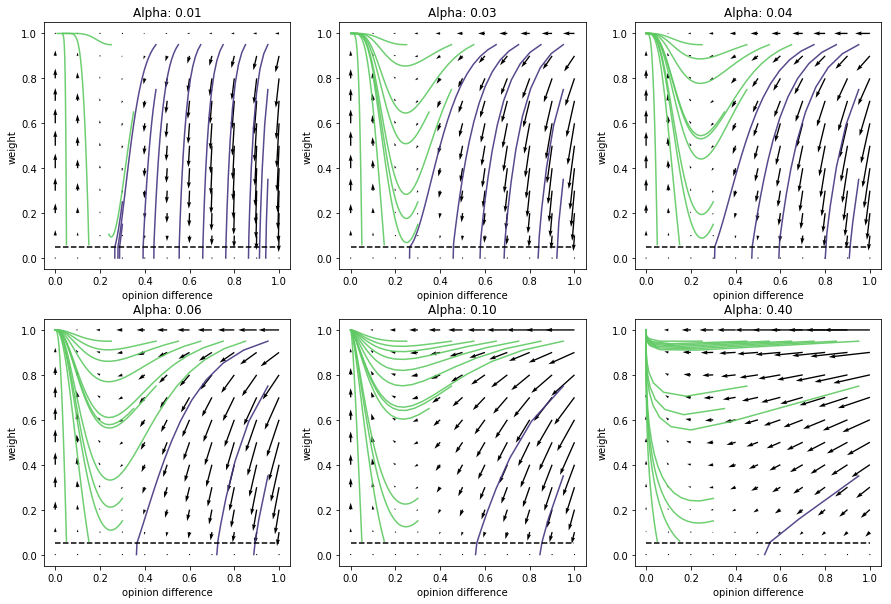

-- Betas -- 


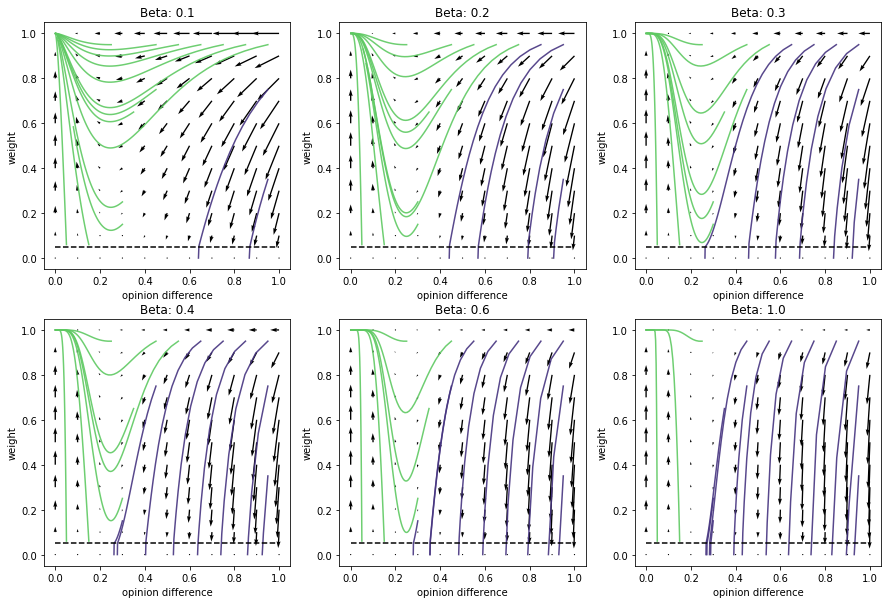

-- Gammas -- 


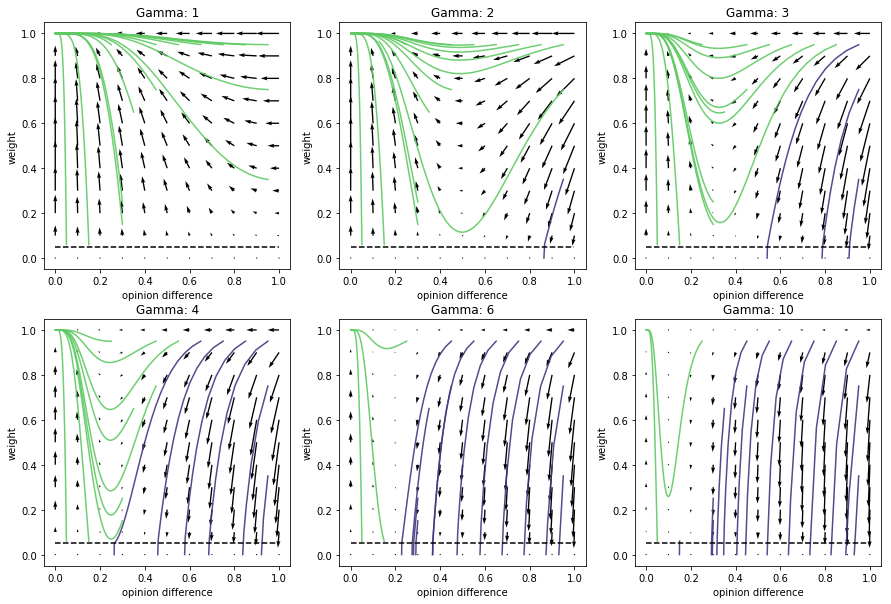

In [270]:
alphas = [0.01, 0.03, 0.04, 0.06, 0.1, 0.4]
betas = [0.1, 0.2, 0.3, 0.4, 0.6, 1]
gammas = [1, 2, 3, 4, 6, 10]

plot_vectorfield(alphas, betas, gammas)

## Part 3 - Implementation
Because I am interested in the impact of tau in a model that is harder to predict (as described above), I have chosen a Barabasi-Albert graph model with preferential attachment for the simulation below. Parameter m for the model has been set to 3. 

The plotting function using the "shell" argument displays only connections that are made accross differing opinions $(|o_i-o_j| > 0.1)$, since my main interest in each augmentation was to see how it would impact opinion divergence (or how long it takes for clusters to separate). 

In [25]:
import sys
sys.path.append("/usr/local/lib/python3.7/site-packages")

from matplotlib import pyplot as plt
%matplotlib inline
import networkx as nx
import numpy as np
import random as rd

rd.seed(1)

In [332]:
class SocialDynamicsSimulation:
    '''
    Simulate social dynamics by strengthening opinions and connection weights
    based on random interactions between nodes.
    '''

    def __init__(self, network_size=50, alpha=0.03, beta=0.3, gamma=4,
                 mod_age = False, mod_effort = False):
        '''
        Inputs:

            network_size (int) The number of nodes in the random Watts-Strogatz
            small-world network. Default: 50.

            alpha (float) speed of opinion change with which the nodes will
            change their opinions to fit or move away from their neighbors.
            With modification 1, this is replaced by tau.
            Default: 0.03. Range: (0,0.5]

            beta (float) scales the amount by which weights change, meaning how
            quickly differing opinions can affect the strength of an existing
            relationship between two nodes. Default: 0.3. Range: (0,1)

            gamma (float) determines how much a difference in opinions affects
            weight change.
            Default: 4.
            
            Mod_age and mod_effort enable extension 1 and 2 respectively.
        '''
        self.network_size = network_size
        self.mod_age = mod_age
        self.mod_effort = mod_effort
        self.finished = False
        
        self.alpha = [alpha, alpha]
        self.beta = beta
        self.gamma = gamma


    def initialize(self):
        '''
        Initialize the simulation with a random graph, with random 0 or 1
        opinions assigned to all nodes and initial edge weights of 0.5.
        Initiates the age of a connection to 1.
        '''
        self.graph = nx.barabasi_albert_graph(self.network_size, 3)
        self.cross_cluster_connections = len(self.graph.edges)

        for edge in self.graph.edges:
            self.graph.edges[edge]['weight'] = 0.5
            
        for node in self.graph.nodes:
            self.graph.nodes[node]['opinion'] = rd.randint(0, 1)
            
        self.layout = nx.spring_layout(self.graph)
        self.step = 0
        
        if self.mod_age:
            for edge in self.graph.edges:
                self.graph.edges[edge]['age'] = 1
                

    def get_layout(self, graph_type = "shell"):
        '''
        Retrieves parameters for plotting.
        Graph types:
        
            "spring" (str) default graph layout with nodes arranged randomly.
            
            "shell" (str) two-layer shell layout with nodes arranged by 
            their opinion (above or below 0.5). Displays only connections
            that exist between nodes with opinions that differ by at least
            0.1.
        '''
        self.plotting = self.graph.copy()
        
        if graph_type == "shell":
            
            inner_shell = []
            outer_shell = []

            for node in self.graph.nodes:
                if self.graph.node[node]['opinion'] > 0.5:
                    inner_shell.append(node)
                else: outer_shell.append(node)

            shell_pos = [inner_shell, outer_shell]
            

            edges_to_remove = []
            for edge in self.plotting.edges:
                n_1 = self.plotting.nodes[edge[0]]['opinion']
                n_2 = self.plotting.nodes[edge[1]]['opinion']
                                
                if abs(n_1 - n_2) < 0.1:
                    edges_to_remove.append(edge)

            if edges_to_remove:
                for edge in edges_to_remove:
                    self.plotting.remove_edge(*edge)
        
            self.layout = nx.shell_layout(self.plotting, nlist=shell_pos)
        
        if graph_type == "spring":
            self.layout = nx.spring_layout(self.plotting, pos=self.layout, iterations=5)
        

    def update(self, end_if_broken = True):
        """
        Updates the simulation by a single time step. 
        """
        self.form_connection()
               
        if not self.finished:
            self.check_clustering()
            self.step += 1
        elif end_if_broken:
            return
        
        if rd.uniform(0, 1) < 0.99:
            edge = rd.choice(list(self.graph.edges))             #pick a random node
            weight = self.graph.edges[edge]['weight']
            opinions = [self.graph.nodes[n]['opinion'] for n in edge]

            for i in [0, 1]:
                if self.mod_age:
                    alpha = self.determine_tau(edge)             #get tau values if needed
                    self.graph.edges[edge]['age'] += 1           #update age after interaction
                else:
                    alpha = self.alpha

                self.graph.nodes[edge[i]]['opinion'] = (         #update opinion
                    opinions[i] + alpha[i] * weight * (opinions[1-i] - opinions[i]))


            self.graph.edges[edge]['weight'] = (                 #update weights
                weight +
                self.beta * weight * (1-weight) *
                (1 - self.gamma * abs(opinions[0] - opinions[1])))

            if self.graph.edges[edge]['weight'] < 0.05:          #remove connection if too weak
                self.graph.remove_edge(*edge)

        
    
    def check_clustering(self):
        self.clustering = self.graph.copy()
        
        edges_to_remove = []
        for edge in self.clustering.edges:
            n_1 = self.clustering.nodes[edge[0]]['opinion']
            n_2 = self.clustering.nodes[edge[1]]['opinion']

            if abs(n_1 - n_2) < 0.1:
                edges_to_remove.append(edge)

        if edges_to_remove:
            for edge in edges_to_remove:
                self.clustering.remove_edge(*edge)
        
        if not self.clustering.edges:
            self.finished = True
#             print("Disconnected the graph at %d steps." %self.step)

        
    def determine_tau(self, edge):
        """
        Intakes an edge and returns a tuple for each node's tau value.
        Tau is determined by age/ 2 * sum total connection ages, but never
        less than the alpha value.
        """
        taus = [0, 0]
        
        for i in [0, 1]:
            age = self.graph.edges[edge]['age']
            con_ages = [self.graph.edges[e]['age'] for e in self.graph.edges(edge[i])]            
            sum_age = np.sum(con_ages)
            
            taus[i] = age/(2* sum_age)
            if taus[i] < self.alpha[i]:
                taus[i] = self.alpha[i]
            
        return taus
        
        
    def form_connection(self):
        """
        Creates a random new connection with a chance of 1% between
        two previously unconnected nodes.
        
        If the "make an effort" modification is enabled, this will instead
        test to see if a node generates a connection between two of its
        friends with the largest differing opinions.
        """
        if rd.uniform(0, 1) < 0.01:
            nodes = list(self.graph.nodes)

            if self.mod_effort:
                rd.shuffle(nodes)                         #random check (instead of while loop)
                
                for host in nodes:
                    friends = list(self.graph.neighbors(host))
                    
                    if len(friends) >= 2:
                        max_diff = 0
                        max_diff_nodes = (0, 0)           #records the nodes with largest difference
                                                          #if it's the same, pick two random friends
                        
                        for i in range(len(friends)):     #compare all friends' opinions
                            for j in range(i):
                                
                                if (i, j) not in self.graph.edges:
                                    diff = abs(self.graph.nodes[friends[i]]['opinion'] -
                                               self.graph.nodes[friends[j]]['opinion'])
                                    if diff > max_diff:
                                        max_diff = diff
                                        max_diff_nodes = (friends[i], friends[j])
                                        
                        if max_diff > 0:
#                             print("Connecting %s from %d's friends." %(str(max_diff_nodes), host))
                            self.graph.add_edge(max_diff_nodes[0], max_diff_nodes[1], weight=0.5, age=1)
                            break       
            else:                                         #default add random connection
                while True:
                    new_edge = rd.sample(nodes, 2)
                    if new_edge not in self.graph.edges:
                        break
                    
                self.graph.add_edge(new_edge[0], new_edge[1], weight=0.5, age=1)
        
        
    
    def run(self, runs = 9, step_size = 2000, visualize = True,
            graph_type = "shell"):
        """
        Runs the simulation and visulizes the results in a grid.
        For simplicity in plotting, number of runs are is changed
        to fit with the grid.
        
        Plotting parameters are retrieved from get_layout(), this is
        particularly imporant for shell-type plots.
        """
        if visualize:
            
            while runs % 3 != 0:
                runs += 1
            
            n = 3
            m = np.ceil(runs/n)
            
            plot_ind = 1

            f, axes = plt.subplots(int(m), n , figsize=(n*4, m*4), sharex=True, sharey=True)

            for r in range(runs):  
                self.get_layout(graph_type)
                
                plt.subplot(int(m), n , plot_ind)    
                nx.draw(
                    self.plotting, pos=self.layout, with_labels=True,
                    node_color=[self.plotting.nodes[i]['opinion'] for i in self.plotting.nodes],
                    edge_color=[self.plotting.edges[i, j]['weight'] for i, j in self.plotting.edges],
                    edge_cmap=plt.cm.binary, edge_vmin=0, edge_vmax=1,
                    cmap=plt.cm.coolwarm, node_vmin=0, node_vmax=1,
                    alpha=0.7, vmin=0, vmax=1)

                plt.title('Step: ' + str(self.step))
                
                plot_ind += 1
                for step in range(step_size):
                    self.update(end_if_broken = False)

            f.tight_layout()
        else:
            for r in range(runs):
                for step in range(step_size):
                    self.update()


### Part 4 - Analysis
Having determine reasonable parameters for the simulation in Part 2, we can now see how each of the scenarios impacts the time it takes for the two opinion clusters to disconnect.
As we can see from the figure below, the basic simulation has a relatively spread out distribution for how long it takes until the graph will disconnect over opinion differences, meaning that it most likely depends a lot on the initial configuration and the random aspects of adding new connections/updating order. Adding an age parameter changes little about this fact, suggesting that making your opinion more heavily dependent on long-term friendships does not necessarily lead to stronger clustering and hence faster network disconnect.

Making an effort to connect your friends with largest opinion disparity (as opposed to random), on the other hand, actually leads to increased clustering and breaks the network apart faster than usual. This is interesting, since intuitively we would expect the opposite effect to take place. These results might be due to the fact that random connections are just as likely to be within clusters as they are to be across clusters, while each node is more likely to have friends that are in its own cluster (even if their opinions differ). This suggests that, in order to reduce social opinions becoming isolated, it is much more effective to occasionally meet a new, random person, than it is to be introduced to someone your friend knows to disagree with you, since they are likely to have selection bias amongst their friends already.

In [388]:
def analysis(runs = 100):
    time_steps = 5000
    scenarios = [(False, False), (True, False), (False, True), (True, True)]
    
    alpha = 0.03
    beta = 0.3
    gamma = 4  
    
    time_to_discon = np.zeros((runs, len(scenarios)))
    
    for s, scenario in enumerate(scenarios):
        for r in range(runs):
            sim = SocialDynamicsSimulation(network_size=50, alpha = alpha, 
                                    beta = beta, gamma = gamma,
                                    mod_age=scenario[0], mod_effort=scenario[1])
            sim.initialize()
            sim.run(1, time_steps, False)
            time_to_discon[r, s] = sim.step
    
    return(time_to_discon) 

time_to_discon = analysis(400)

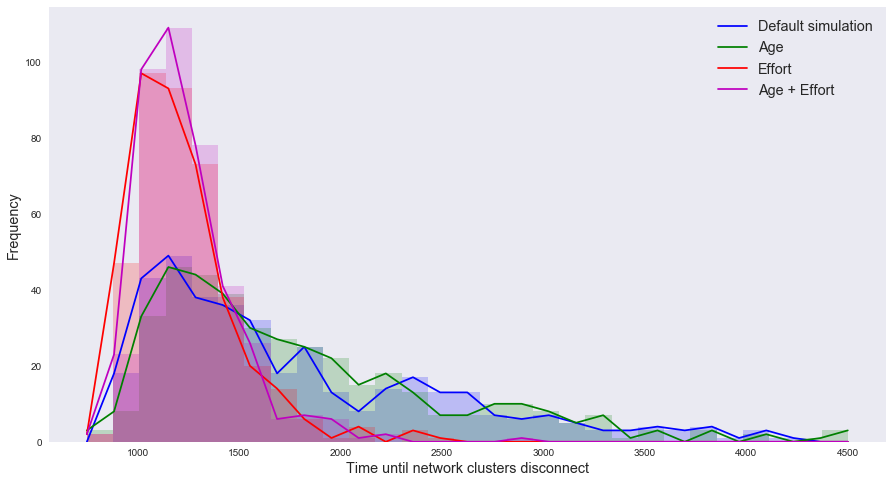

In [404]:
plt.style.use('seaborn-notebook')

x = time_to_discon
bins = np.linspace(750, 4500, 30)
bins_line = np.linspace(750, 4500, 29)

plt.figure(figsize=(15, 8))

n,_,_ = plt.hist(x[:,0], bins = bins, alpha = 0.2, color='b')
plt.plot(bins_line, n, color='b', label='Default simulation')

n,_,_ = plt.hist(x[:,1], bins = bins, alpha=0.2, color='g')
plt.plot(bins_line, n, color='g', label='Age')

n,_,_ = plt.hist(x[:,2], bins = bins, alpha=0.2, color='r')
plt.plot(bins_line, n, color='r', label='Effort')

n,_,_ = plt.hist(x[:,3], bins = bins, alpha=0.2, color='m')
plt.plot(bins_line, n, color='m', label='Age + Effort')

plt.legend(loc='upper right', fontsize = 'x-large')
plt.xlabel("Time until network clusters disconnect", fontsize = 'x-large')
plt.ylabel("Frequency", fontsize = 'x-large')
plt.show()

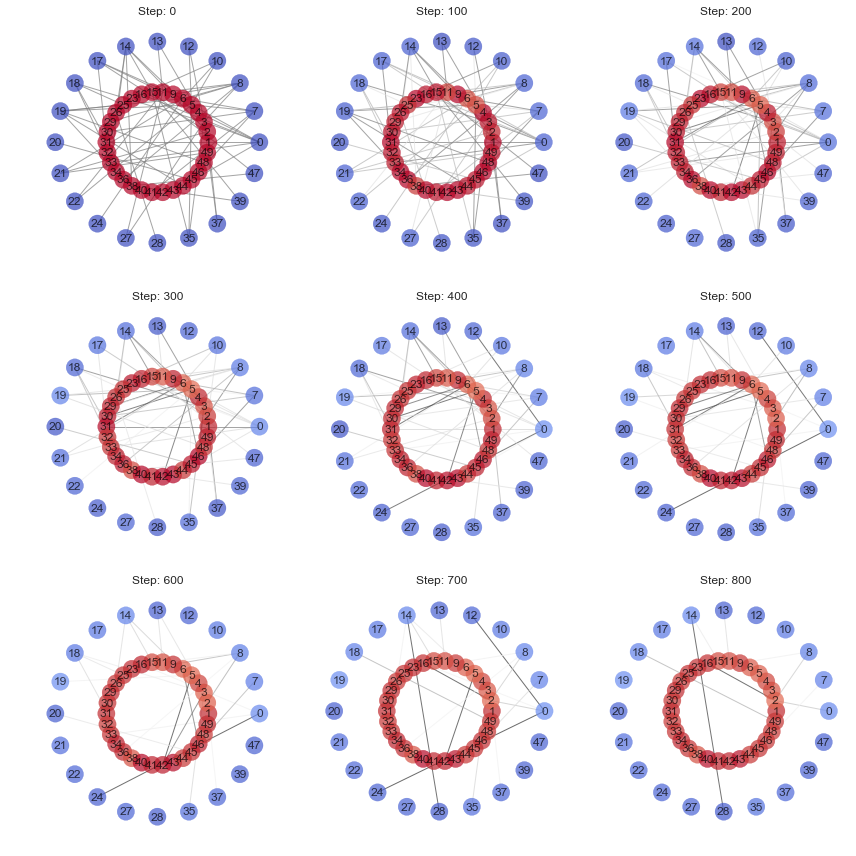

In [405]:
sim = SocialDynamicsSimulation(network_size=50, gamma =4, mod_age=False, mod_effort=False)
sim.initialize()

sim.run(9, 100, graph_type = "shell")

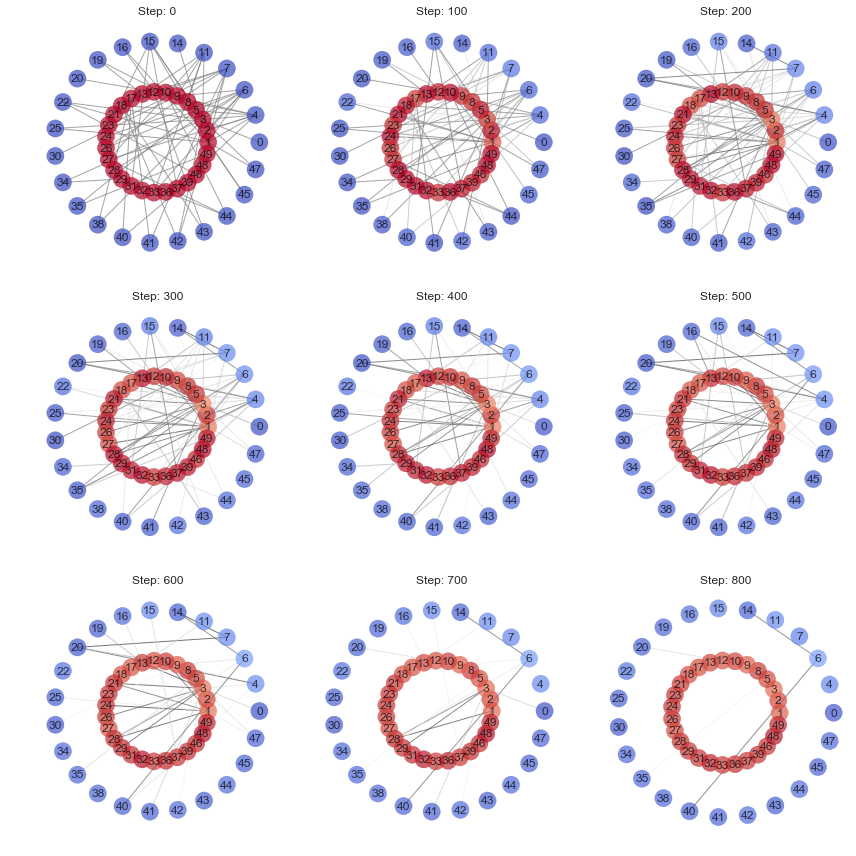

In [406]:
sim = SocialDynamicsSimulation(network_size=50, gamma = 4, mod_age=True, mod_effort=False)
sim.initialize()

sim.run(9, 100, graph_type = "shell")

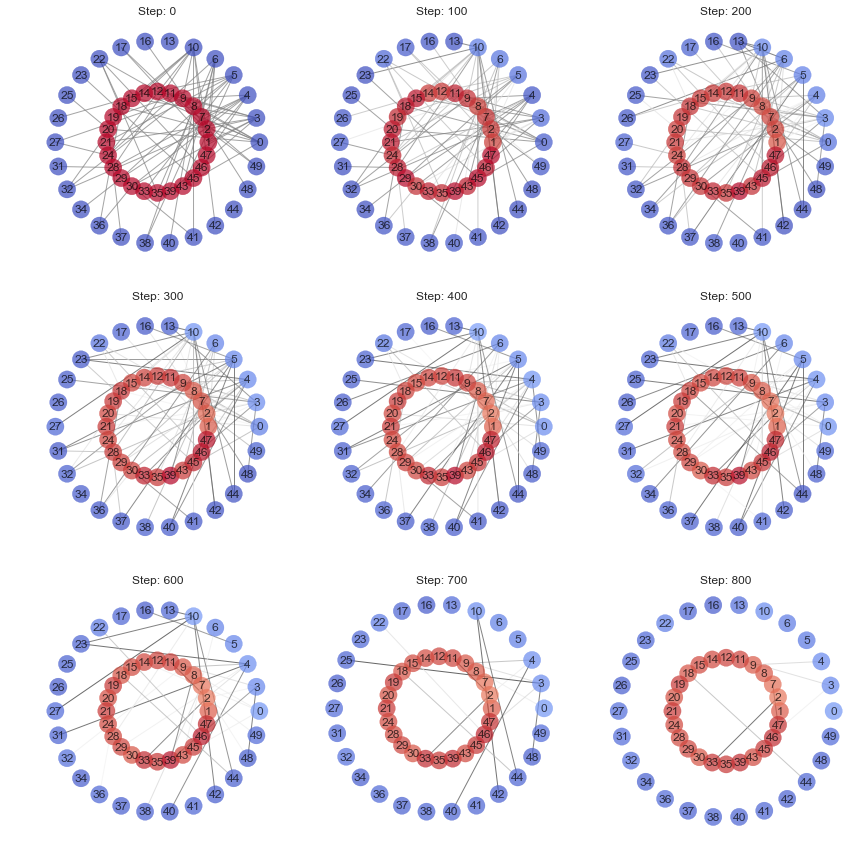

In [407]:
sim = SocialDynamicsSimulation(network_size=50, gamma = 4, mod_age=False, mod_effort=True)
sim.initialize()

sim.run(9, 100, graph_type = "shell")

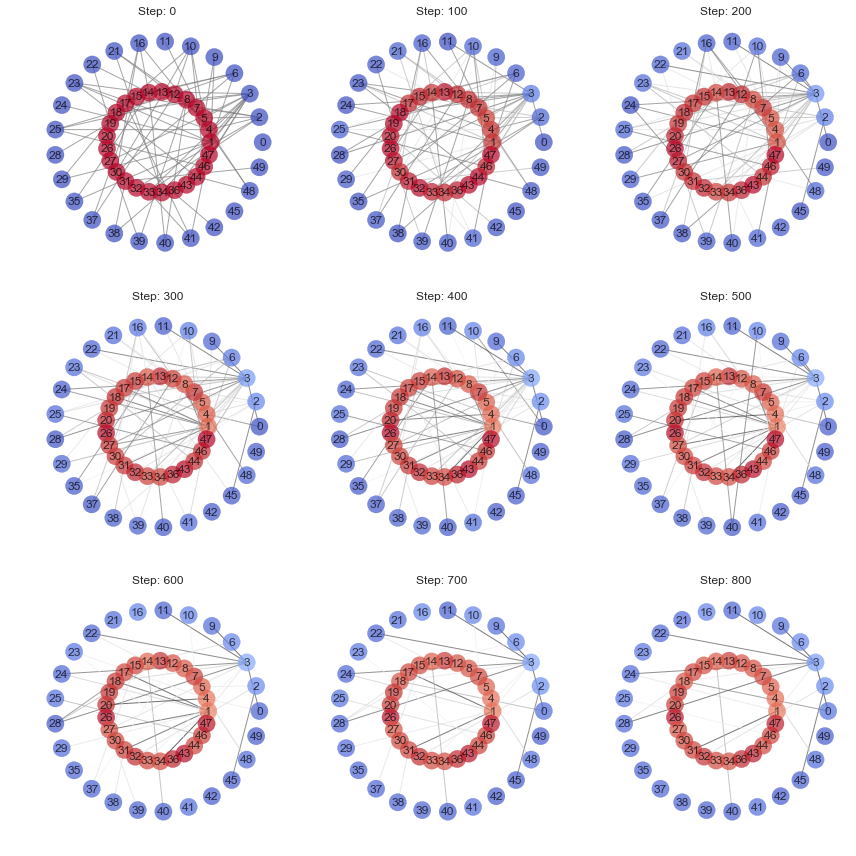

In [408]:
sim = SocialDynamicsSimulation(network_size=50, gamma = 4, mod_age=True, mod_effort=True)
sim.initialize()

sim.run(9, 100, graph_type = "shell")